# Standalone Validation

Import the libraries.

In [1]:
import os
import sys

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import sympy as sp
import torch
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import the equations for the standalone validation experiment.

In [2]:
from strogatz_equations import equations

Import the S-MNN module.

In [3]:
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else '', '..', '..')))
from smnn import ode_forward

## Data Processing

For a given equation, create sympy expressions where the different parameter values have been substituted in.

In [4]:
def convert_inplace(nested_list: list | tuple, subs: dict) -> list | tuple:
    for i in range(len(nested_list)):
        if isinstance(nested_list[i], list | tuple):
            convert_inplace(nested_list[i], subs)
        else:
            nested_list[i] = sp.sympify(nested_list[i]).subs(subs)
    return nested_list

We directly add the list of expressions to each dictionary.

In [5]:
for eq_dict in equations:
    const_symbols = sp.symbols([f'c_{i}' for i in range(len(eq_dict['consts'][0]))])
    eq_dict['substituted_gt'] = [
        convert_inplace(eq_dict['eq_gt'].split('|'), dict(zip(const_symbols, consts)))
        for consts in eq_dict['consts']
    ]
    eq_dict['substituted_mnn'] = [
        convert_inplace(eq_dict['mnn'], dict(zip(const_symbols, consts)))
        for consts in eq_dict['consts']
    ]

## Solving

Compute the closed-form solutions for all equations.

In [6]:
for eq_id, eq_dict in enumerate(tqdm(equations)):
    eq_dict['solutions_gt'] = []
    init_symbols = sp.symbols([f'i_{i}' for i in range(eq_dict['dim'])])
    t = np.arange(0., 10., 1e-2)
    for i, fns in enumerate(eq_dict['substituted_gt']):
        eq_dict['solutions_gt'].append([])
        for initial_conditions in eq_dict['init']:
            y = np.array([sp.lambdify(
                't', eq.subs(zip(init_symbols, initial_conditions)), 'numpy',
            )(t) for eq in fns])
            y1 = np.array([sp.lambdify(
                't', sp.diff(eq, sp.symbols('t'), 1).subs(zip(init_symbols, initial_conditions)), 'numpy',
            )(t) for eq in fns])
            y2 = np.array([sp.lambdify(
                't', sp.diff(eq, sp.symbols('t'), 2).subs(zip(init_symbols, initial_conditions)), 'numpy',
            )(t) for eq in fns])
            eq_dict['solutions_gt'][i].append({
                "t": t.tolist(),
                "y": y.tolist(),
                "y1": y1.tolist(),
                "y2": y2.tolist(),
                'consts': eq_dict['consts'][i],
                'init': initial_conditions,
            })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 18.49it/s]


Compute the S-MNN solutions for all equations.

In [7]:
for eq_id, eq_dict in enumerate(tqdm(equations)):
    eq_dict['solutions_mnn'] = []
    dtype = torch.float64
    device = torch.device('cpu')
    for i, fns in enumerate(eq_dict['substituted_mnn']):
        eq_dict['solutions_mnn'].append([])
        n_orders = 3
        coefficients = torch.tensor([eq_dict['mnn'][0]], dtype=dtype, device=device)  # (n_steps[b]=1, n_equations, n_dims, n_orders)
        coefficients = torch.cat([
            coefficients,
            *([torch.zeros_like(coefficients[..., :1])] * (n_orders - coefficients.size(-1))),
        ], dim=-1).contiguous()  # (n_steps[b]=1, n_equations, n_dims, n_orders=3)
        rhs_equation = torch.tensor([eq_dict['mnn'][1]], dtype=dtype, device=device).contiguous()
        # (n_steps[b]=1, n_equations)
        step_length = 1e-2
        steps = torch.tensor([step_length], dtype=dtype, device=device).contiguous()  # (n_steps-1[b]=1)
        n_steps = int(10. / step_length)
        for initial_conditions in eq_dict['init']:
            init_vars = torch.tensor(initial_conditions, dtype=dtype, device=device)[None, ..., None].contiguous()
            # (n_init_var_steps=1, n_dims, n_init_var_orders=1)
            y = ode_forward(
                coefficients, rhs_equation, init_vars, steps, n_steps=n_steps, is_step_dim_first=True, enable_central_smoothness=False,
            ).permute(1, 2, 0)  # (n_dims, n_orders=3, n_steps)
    
            eq_dict['solutions_mnn'][i].append({
                "t": np.arange(0., 10., step_length).tolist(),
                "y": y.tolist(),
                'consts': eq_dict['consts'][i],
                'init': initial_conditions,
        })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 19.90it/s]


## Plotting

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 250.29it/s]


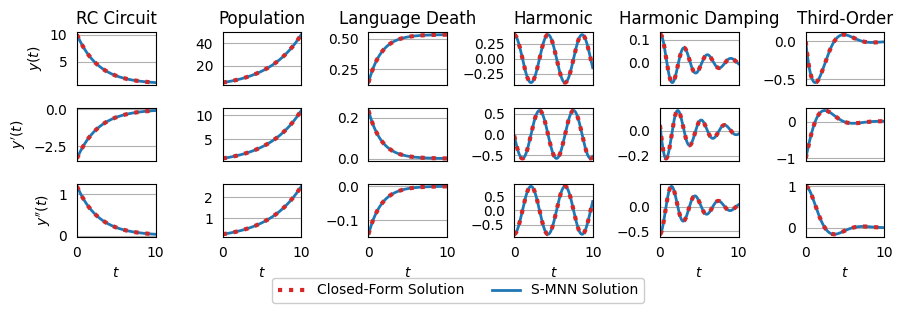

In [8]:
plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

experiment_titles = ['RC Circuit', 'Population', 'Language Death', 'Harmonic', 'Harmonic Damping', 'Third-Order']

rows = 3
cols = len(experiment_titles)
const_i, init_i = 0, 0
fig, axs = plt.subplots(rows, cols, figsize=(1.5 * cols, 1. * rows), sharex=True)

# Loop over all equations
for j, eq_dict in enumerate(tqdm(equations)):

    axs[0, j].set_title(experiment_titles[j])
    axs[-1, j].set_xlabel('$t$')
    axs[-1, j].set_xlim(0., 10.)

    solution_gt = eq_dict['solutions_gt'][const_i][init_i]
    solution_mnn = eq_dict['solutions_mnn'][const_i][init_i]

    for i in range(rows):
        axs[i, j].plot(
            solution_mnn['t'], solution_mnn['y'][0][i],
            label='S-MNN Solution', color=plot_colors[0], linestyle='-', linewidth=2., alpha=1.,
        )
        axs[i, j].plot(
            solution_gt['t'], solution_gt[f'y{i if i > 0 else ""}'][0],
            label='Closed-Form Solution', color=plot_colors[3], linestyle=':', linewidth=3., alpha=1.,
        )
        axs[i, j].grid()
        axs[i, j].set_facecolor((1., 1., 1., 1.))
        axs[i, j].xaxis.set_ticks_position('none')
        axs[i, j].yaxis.set_ticks_position('none')

for i in range(rows):
    axs[i, 0].set_ylabel(f'$y{"'"*i}(t)$')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc='lower center', ncol=2, framealpha=1., bbox_to_anchor=(.5, -.05))
fig.set_facecolor((1., 1., 1., 0.))
fig.tight_layout()

# fig.savefig('standalone_validation_trajectories.pdf', format='pdf', bbox_inches='tight', pad_inches=.01, transparent=False)
plt.show()
plt.close(fig)